In [364]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
import sklearn
from sklearn.decomposition import PCA

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='whitegrid', font='CMU Serif', rc={'font.size':12, 'mathtext.fontset': 'cm', "grid.linewidth": 0.5, "axes.grid": True, "axes.grid.axis": "x"})

# Fast vs Slow

In [2]:
class Inputs():
    def __init__(self, deltaP, maxSamples, empirical=None, seed=0):
        self.deltaP = deltaP
        self.maxSamples = maxSamples
        self.empirical = empirical
        self.winning = None
        self.pA = None
        self.pB = None
        self.dP_actual = None
        self.As = []
        self.Bs = []
        self.rng = np.random.RandomState(seed=seed)
    def set_AB(self):
        self.winning = "A" if self.rng.rand()<0.5 else "B"
        highs = np.arange(0.1+self.deltaP, 0.9, 0.1)
        high = highs[self.rng.randint(len(highs))]
        low = high - self.deltaP
        nUpWin = int(high*self.maxSamples)
        nUpLose = int(low*self.maxSamples)
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if self.winning=="A":
            self.As[:nUpWin] = 1
            self.As[nUpWin:] = -1
            self.Bs[:nUpLose] = 1
            self.Bs[nUpLose:] = -1
            self.pA = nUpWin / self.maxSamples
            self.pB = nUpLose / self.maxSamples
        else:
            self.Bs[:nUpWin] = 1
            self.Bs[nUpWin:] = -1
            self.As[:nUpLose] = 1
            self.As[nUpLose:] = -1
            self.pB = nUpWin / self.maxSamples
            self.pA = nUpLose / self.maxSamples
        self.rng.shuffle(self.As)
        self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def set_AB_empirical(self, trial, initialize=True):
        self.pA = self.empirical['pA'].to_numpy()[trial]
        self.pB = self.empirical['pB'].to_numpy()[trial]
        self.winning = "A" if self.pA>self.pB else "B"
        self.As = np.zeros((self.maxSamples))
        self.Bs = np.zeros((self.maxSamples))
        if initialize:  # populate the A and B arrays with the samples actually drawn in the empirical trial
            empAs = list(str(self.empirical['A'].to_numpy()[trial]))
            empAs = np.array([2*int(x)-1 for x in empAs])
            empBs = list(str(self.empirical['B'].to_numpy()[trial]))
            empBs = np.array([2*int(x)-1 for x in empBs])
            self.As[:len(empAs)] = empAs
            self.Bs[:len(empBs)] = empBs
            self.As[len(empAs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empAs))-1
            self.Bs[len(empBs):] = 2*self.rng.randint(2, size=self.maxSamples-len(empBs))-1
        else:
            if self.winning=="A":
                self.As[:nUpWin] = 1
                self.As[nUpWin:] = -1
                self.Bs[:nUpLose] = 1
                self.Bs[nUpLose:] = -1
            else:
                self.Bs[:nUpWin] = 1
                self.Bs[nUpWin:] = -1
                self.As[:nUpLose] = 1
                self.As[nUpLose:] = -1
            self.rng.shuffle(self.As)
            self.rng.shuffle(self.Bs)
        self.dP_actual = np.abs(self.pA - self.pB)
    def get_AB(self, t):
        AB = [self.As[int(t)], self.Bs[int(t)]] if t<self.maxSamples else [0,0]
        AB = [AB[0], 0] if t%1.0<0.5 else [0, AB[1]]  # A presented for 500ms, then B presented for 500ms
        return AB

In [3]:
def build_network(inputs, nNeurons=1000, tau=0.1, seed=0, w_time=0, w_ramp=0.2, w_delta=0, T=0.3, S=[0,0]):
    
    net = nengo.Network(seed=seed)
    net.config[nengo.Connection].synapse = 0.03
    net.config[nengo.Probe].synapse = 0.03
    
    func_evidence = lambda t: inputs.get_AB(t)
    func_thr = lambda t: T
    func_start = lambda t: S if t<1 else [0,0]
    func_urgency = lambda t: -w_time * t
    func_ramp = lambda x: tau * w_ramp * x
    func_uncertainty = lambda x: -w_delta * np.abs(x[0]-x[1])
    func_greater = lambda x: [x[0]-x[1], x[1]-x[0]] 
    
    ePos = nengo.dists.Choice([[1]])
    iPos = nengo.dists.Uniform(0.01, 1)
    dInh = -1e1*np.ones((2*nNeurons, 1))

    with net:
        # Inputs
        evidence = nengo.Node(func_evidence)
        time = nengo.Node(func_urgency)
        thr = nengo.Node(func_thr)
        start = nengo.Node(func_start)
        
        # Ensembles
        value = nengo.networks.EnsembleArray(nNeurons, 2)
        accumulate = nengo.networks.EnsembleArray(nNeurons, 2)
        combined = nengo.Ensemble(2*nNeurons, 2)
        gate = nengo.Ensemble(nNeurons, 1, encoders=ePos, intercepts=iPos)
        action = nengo.networks.EnsembleArray(nNeurons, 2, encoders=ePos, intercepts=iPos)
        
        # Connections
        nengo.Connection(evidence, value.input)
        nengo.Connection(start[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(start[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[0], accumulate.ea_ensembles[0], synapse=tau, function=func_ramp)
        nengo.Connection(value.ea_ensembles[1], accumulate.ea_ensembles[1], synapse=tau, function=func_ramp)
        nengo.Connection(accumulate.output, accumulate.input, synapse=tau)
        nengo.Connection(accumulate.output, combined)
        nengo.Connection(combined, gate, function=func_uncertainty)
        nengo.Connection(combined, action.input, function=func_greater)
        nengo.Connection(time, gate)
        nengo.Connection(thr, gate)
        nengo.Connection(gate, action.input, transform=[[-1], [-1]])

        # Probes
        net.pEvidence = nengo.Probe(evidence)
        net.pValue = nengo.Probe(value.output)
        net.pAccumulate = nengo.Probe(accumulate.output)
        net.pGate = nengo.Probe(gate)
        net.pAction = nengo.Probe(action.output)
        
        # references
        net.w_ramp = w_ramp
        net.w_delta = w_delta
        
    return net

In [235]:
def is_correct(inputs, net, sim, dt=0.001, action_threshold=0.0):
    chooseA = np.argwhere(sim.data[net.pAction][:,0] > action_threshold)
    chooseB = np.argwhere(sim.data[net.pAction][:,1] > action_threshold)
    timeA = chooseA[0][0]*dt if len(chooseA)>0 else sim.trange()[-1]
    timeB = chooseB[0][0]*dt if len(chooseB)>0 else sim.trange()[-1]
    if inputs.winning=="A":
        if timeA == timeB:  # forced response
            correct = 1 if sim.data[net.pAccumulate][-1][0] > sim.data[net.pAccumulate][-1][1] else False
            time = timeA
        elif timeA < timeB:
            correct = 1
            time = timeA
        elif timeB < timeA:
            correct = 0
            time = timeB
    elif inputs.winning=="B":
        if timeB == timeA:  # forced response
            correct = 1 if sim.data[net.pAccumulate][-1][1] > sim.data[net.pAccumulate][-1][0] else False
            time = timeB
        elif timeB < timeA:
            correct = 1
            time = timeB
        elif timeA < timeB:
            correct = 0
            time = timeA
    return correct, int(np.ceil(2*time)), time

In [306]:
def run_trials(args, deltaPs=[0.4, 0.2, 0.1], load=False):
    participant_id = args['participant_id']
    if load:
        data = pd.read_pickle(f"data/{participant_id}.pkl")
    else:
        dfs = []
        columns = ('agent', 'dP', 'trial', 'cues', 'correct')
        for dP in deltaPs:
            empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12 & delta==@dP & participant_id==@participant_id")
            empirical_cues = empirical_data['cues'].to_numpy()
            empirical_accuracy = empirical_data['correct'].to_numpy()
            inputs = Inputs(deltaP=dP, maxSamples=12, seed=args['seed'], empirical=empirical_data)
            inputs.set_AB_empirical(0)
            net = build_network(inputs, T=args['T'], w_ramp=args['w_ramp'], w_time=args['w_time'], w_delta=args['w_delta'], seed=args['seed'])

            for trial in range(empirical_data.shape[0]):
                print(f"trial {trial}")
                inputs.set_AB_empirical(trial)
                sim = nengo.Simulator(net, progress_bar=False)
                with sim:
                    sim.run(12, progress_bar=True)
                correct, cue, time = is_correct(inputs, net, sim)
                dfs.append(pd.DataFrame([['model', dP, trial, cue, 1.0*correct,]], columns=columns))
                dfs.append(pd.DataFrame([['human', dP, trial, empirical_cues[trial], 1.0*empirical_accuracy[trial]]], columns=columns))

        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{participant_id}.pkl")
    return data

In [307]:
args_fast = {
    'participant_id': '58c54d6d2775404a9c3a3cde65c32a71',
    'seed':74,
    'T':0.31,
    'w_ramp':0.1,
    'w_time':0.04,
    'w_delta':0.7,
}
fast_data = run_trials(args=args_fast, load=True)
print(fast_data)

     agent   dP  trial  cues  correct
0    model  0.4      0     5      1.0
1    human  0.4      0     5      1.0
2    model  0.4      1     7      0.0
3    human  0.4      1     6      0.0
4    model  0.4      2     8      1.0
..     ...  ...    ...   ...      ...
283  human  0.1     45    13      0.0
284  model  0.1     46     8      1.0
285  human  0.1     46     5      1.0
286  model  0.1     47     7      0.0
287  human  0.1     47     6      0.0

[288 rows x 5 columns]


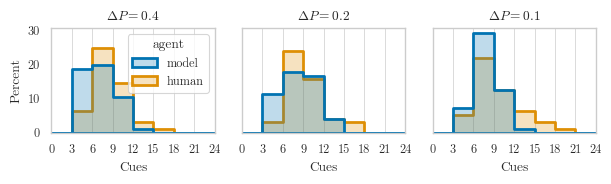

In [308]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((6.28, 2)))
sns.histplot(data=fast_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=fast_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=fast_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[2], stat='percent', multiple='layer', element='step', linewidth=2)
axes[0].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.4$')
axes[1].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.2$')
axes[2].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.1$')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/fast.svg")
fig.savefig(f"plots/fast.png", dpi=600)

In [309]:
a_human_hard = fast_data.query("dP==0.1 & agent=='human'")['correct'].mean()
a_model_hard = fast_data.query("dP==0.1 & agent=='model'")['correct'].mean()
a_human_medium = fast_data.query("dP==0.2 & agent=='human'")['correct'].mean()
a_model_medium = fast_data.query("dP==0.2 & agent=='model'")['correct'].mean()
a_human_easy = fast_data.query("dP==0.4 & agent=='human'")['correct'].mean()
a_model_easy = fast_data.query("dP==0.4 & agent=='model'")['correct'].mean()

print(f'hard: human={a_human_hard:.3f}, model={a_model_hard:.3f}')
print(f'medium: human={a_human_medium:.3f}, model={a_model_medium:.3f}')
print(f'easy: human={a_human_easy:.3f}, model={a_model_easy:.3f}')

hard: human=0.667, model=0.667
medium: human=0.750, model=0.792
easy: human=0.896, model=0.979


In [301]:
args_slow = {
    'participant_id': 'ece1f226b161426aafd433aa0e933b5d',
    'seed':417,
    'T':0.21,
    'w_ramp':0.12,
    'w_time':0.0,
    'w_delta':0.0,
}
slow_data = run_trials(args=args_slow, load=False)
print(slow_data)

trial 0


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 1


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 2


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 3


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 4


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 7


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 11


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 12


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 13


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 15


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 17


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 18


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 19


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 20


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 21


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 22


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 23


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 24


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 0


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 1


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 2


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 3


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 4


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 5


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 6


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 7


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 8


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 11


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 12


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 13


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 14


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 15


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 16


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 17


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 19


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 20


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 21


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 22


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 23


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 24


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 25


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 0


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 1


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 2


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 3


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 4


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 5


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 6


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 7


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 8


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 9


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 10


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 11


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 12


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 13


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 14


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 15


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 16


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 17


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:609: UserWarning: Decoder cache could not acquire lock and was set to readonly mode.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 18


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 19


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 20


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 21


/home/pduggins/.local/share/virtualenvs/value-accumulation-mUbM87nN/lib/python3.10/site-packages/nengo/cache.py:554: UserWarning: Decoder cache index could not acquire lock. Cache index was not synced.
  warnings.warn(


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 22


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 23


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

trial 24


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

     agent   dP  trial  cues  correct
0    model  0.4      0    14      1.0
1    human  0.4      0    16      1.0
2    model  0.4      1    11      1.0
3    human  0.4      1    15      1.0
4    model  0.4      2    10      1.0
..     ...  ...    ...   ...      ...
147  human  0.1     22    11      1.0
148  model  0.1     23     9      1.0
149  human  0.1     23    12      1.0
150  model  0.1     24    14      1.0
151  human  0.1     24    11      1.0

[152 rows x 5 columns]


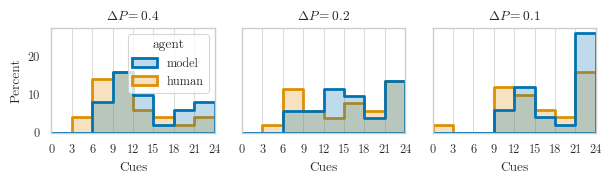

In [303]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=((6.28, 2)))
sns.histplot(data=slow_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=slow_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=slow_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[2], stat='percent', multiple='layer', element='step', linewidth=2)
axes[0].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.4$')
axes[1].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.2$')
axes[2].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), title=r'$\Delta P=0.1$')
axes[1].get_legend().remove()
axes[2].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/slow.svg")
fig.savefig(f"plots/slow.png", dpi=600)

In [310]:
a_human_hard = slow_data.query("dP==0.1 & agent=='human'")['correct'].mean()
a_model_hard = slow_data.query("dP==0.1 & agent=='model'")['correct'].mean()
a_human_medium = slow_data.query("dP==0.2 & agent=='human'")['correct'].mean()
a_model_medium = slow_data.query("dP==0.2 & agent=='model'")['correct'].mean()
a_human_easy = slow_data.query("dP==0.4 & agent=='human'")['correct'].mean()
a_model_easy = slow_data.query("dP==0.4 & agent=='model'")['correct'].mean()

print(f'hard: human={a_human_hard:.3f}, model={a_model_hard:.3f}')
print(f'medium: human={a_human_medium:.3f}, model={a_model_medium:.3f}')
print(f'easy: human={a_human_easy:.3f}, model={a_model_easy:.3f}')

hard: human=0.840, model=0.800
medium: human=0.923, model=0.962
easy: human=1.000, model=0.960


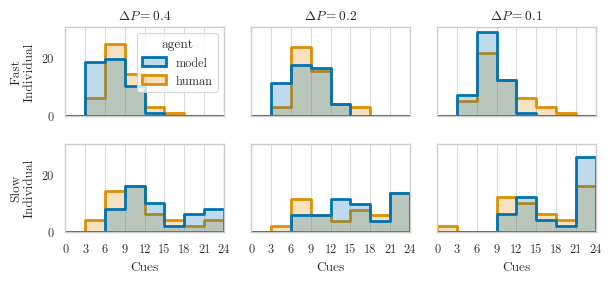

In [316]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, sharex=True, figsize=((6.28, 3)))
sns.histplot(data=fast_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][0], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=fast_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][1], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=fast_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[0][2], stat='percent', multiple='layer', element='step', linewidth=2)
axes[0][0].set(xlabel=None, title=r'$\Delta P=0.4$', ylabel="Fast\nIndividual")
axes[0][1].set(xlabel=None, title=r'$\Delta P=0.2$')
axes[0][2].set(xlabel=None, title=r'$\Delta P=0.1$')
axes[0][1].get_legend().remove()
axes[0][2].get_legend().remove()
sns.histplot(data=slow_data.query("dP==0.4"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][0], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=slow_data.query("dP==0.2"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][1], stat='percent', multiple='layer', element='step', linewidth=2)
sns.histplot(data=slow_data.query("dP==0.1"), x='cues', hue='agent', bins=np.arange(0, 27, 3),
    palette=palette[:2], ax=axes[1][2], stat='percent', multiple='layer', element='step', linewidth=2)
axes[1][0].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)), ylabel='Slow\nIndividual')
axes[1][1].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][2].set(xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][0].get_legend().remove()
axes[1][1].get_legend().remove()
axes[1][2].get_legend().remove()
plt.tight_layout()
fig.savefig(f"plots/fast_and_slow.svg")
fig.savefig(f"plots/fast_and_slow.png", dpi=600)

## Scatter

In [336]:
def run_optimized_agent(pid, args):      
    dfs = []
    dfs2 = []
    columns = ('pid', 'agent', 'dP', 'trial', 'cues', 'correct')
    columns2 = ('pid', 'agent', 'dP', 'trials', 'mean cues', 'mean correct')
    for dP in [0.4, 0.2, 0.1]:
        print(f"dP {dP}")
        empirical_data = pd.read_pickle("empirical_data.pkl").query("maxSamples==12 & delta==@dP & participant_id==@pid")
        empirical_cues = empirical_data['cues'].to_numpy()
        empirical_accuracy = 1.0*empirical_data['correct'].to_numpy()
        inputs = Inputs(deltaP=dP, maxSamples=12, seed=args['seed'], empirical=empirical_data)
        inputs.set_AB_empirical(0)
        net = build_network(inputs, T=args['T'], w_ramp=args['w_ramp'], w_time=args['w_time'], w_delta=args['w_delta'], seed=args['seed'])
        cues = []
        corrects = []
        nTrials = empirical_data.shape[0]
        for trial in range(nTrials):
            print(f"trial {trial}/{nTrials}")
            inputs.set_AB_empirical(trial)
            sim = nengo.Simulator(net, progress_bar=False)
            with sim:
                sim.run(12, progress_bar=False)
            correct, cue, time = is_correct(inputs, net, sim)
            cues.append(cue)
            corrects.append(correct)
            dfs.append(pd.DataFrame([[pid, 'model', dP, trial, cue, correct]], columns=columns))
            dfs.append(pd.DataFrame([[pid, 'human', dP, trial, empirical_cues[trial], empirical_accuracy[trial]]], columns=columns))
        dfs2.append(pd.DataFrame([[pid, 'model', dP, nTrials+1, np.mean(cues), np.mean(corrects)]], columns=columns2))
        dfs2.append(pd.DataFrame([[pid, 'human', dP, nTrials+1, np.mean(empirical_cues), np.mean(empirical_accuracy)]], columns=columns2))
    data = pd.concat(dfs, ignore_index=True)
    data2 = pd.concat(dfs2, ignore_index=True)
    data.to_pickle(f"data/optimized/{pid}.pkl")
    data2.to_pickle(f"data/optimized/{pid}_collapsed.pkl")

In [337]:
f = open('optimized.json')
optimized = json.load(f)
for pid, args in optimized.items():
    print(f'running {pid}')
    run_optimized_agent(pid, args)

running ece1f226b161426aafd433aa0e933b5d
dP 0.4
trial 0/25
trial 1/25
trial 2/25
trial 3/25
trial 4/25
trial 5/25
trial 6/25
trial 7/25
trial 8/25
trial 9/25
trial 10/25
trial 11/25
trial 12/25
trial 13/25
trial 14/25
trial 15/25
trial 16/25
trial 17/25
trial 18/25
trial 19/25
trial 20/25
trial 21/25
trial 22/25
trial 23/25
trial 24/25
dP 0.2
trial 0/26
trial 1/26
trial 2/26
trial 3/26
trial 4/26
trial 5/26
trial 6/26
trial 7/26
trial 8/26
trial 9/26
trial 10/26
trial 11/26
trial 12/26
trial 13/26
trial 14/26
trial 15/26
trial 16/26
trial 17/26
trial 18/26
trial 19/26
trial 20/26
trial 21/26
trial 22/26
trial 23/26
trial 24/26
trial 25/26
dP 0.1
trial 0/25
trial 1/25
trial 2/25
trial 3/25
trial 4/25
trial 5/25
trial 6/25
trial 7/25
trial 8/25
trial 9/25
trial 10/25
trial 11/25
trial 12/25
trial 13/25
trial 14/25
trial 15/25
trial 16/25
trial 17/25
trial 18/25
trial 19/25
trial 20/25
trial 21/25
trial 22/25
trial 23/25
trial 24/25
running 58c54d6d2775404a9c3a3cde65c32a71
dP 0.4
trial 0/

KeyboardInterrupt: 

In [348]:
f = open('optimized.json')
optimized = json.load(f)
dfs = []
for pid, args in optimized.items():
    try:
        dfs.append(pd.read_pickle(f"data/optimized/{pid}_collapsed.pkl"))
    except:
        print(f"no data for {pid}")
sat_data = pd.concat(dfs, ignore_index=True)
print(sat_data.to_string())

                                  pid  agent   dP  trials  mean cues  mean correct
0    ece1f226b161426aafd433aa0e933b5d  model  0.4      26   7.480000      0.960000
1    ece1f226b161426aafd433aa0e933b5d  human  0.4      26  10.920000      1.000000
2    ece1f226b161426aafd433aa0e933b5d  model  0.2      27   8.076923      0.769231
3    ece1f226b161426aafd433aa0e933b5d  human  0.2      27  14.730769      0.923077
4    ece1f226b161426aafd433aa0e933b5d  model  0.1      26   8.280000      0.560000
5    ece1f226b161426aafd433aa0e933b5d  human  0.1      26  16.000000      0.840000
6    58c54d6d2775404a9c3a3cde65c32a71  model  0.4      49   6.958333      0.979167
7    58c54d6d2775404a9c3a3cde65c32a71  human  0.4      49   7.916667      0.895833
8    58c54d6d2775404a9c3a3cde65c32a71  model  0.2      49   7.958333      0.791667
9    58c54d6d2775404a9c3a3cde65c32a71  human  0.2      49   8.770833      0.750000
10   58c54d6d2775404a9c3a3cde65c32a71  model  0.1      49   7.666667      0.666667
11  

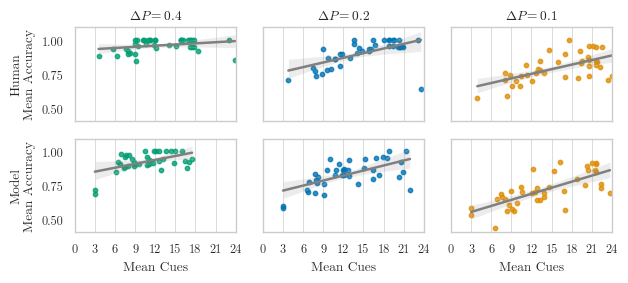

In [350]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True, sharey=True)
sns.regplot(data=sat_data.query("agent=='human' & dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[2], ax=axes[0][0], label='human')
sns.regplot(data=sat_data.query("agent=='human' & dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[0], ax=axes[0][1], label='human')
sns.regplot(data=sat_data.query("agent=='human' & dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[1], ax=axes[0][2], label='human')
sns.regplot(data=sat_data.query("agent=='model' & dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[2], ax=axes[1][0], label='model')
sns.regplot(data=sat_data.query("agent=='model' & dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[0], ax=axes[1][1], label='model')
sns.regplot(data=sat_data.query("agent=='model' & dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 10}, line_kws={'color': 'gray'}, color=palette[1], ax=axes[1][2], label='model')
axes[0][0].set(ylabel='Human\nMean Accuracy', xlabel=None, title=r'$\Delta P=0.4$')
axes[0][1].set(ylabel=None, xlabel=None, title=r'$\Delta P=0.2$')
axes[0][2].set(ylabel=None, xlabel=None, title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[1][0].set(ylabel='Model\nMean Accuracy', xlabel='Mean Cues')
axes[1][1].set(ylabel=None, xlabel='Mean Cues')
axes[1][2].set(ylabel=None, xlabel='Mean Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))

plt.tight_layout()
fig.savefig(f"plots/SAT_scatter.svg")
fig.savefig(f"plots/SAT_scatter.png", dpi=600)

## PCA

In [432]:
f = open('optimized.json')
optimized = json.load(f)
dfs = []
columns = ('pid', 'dP', 'trials', 'mean cues', 'mean correct', 'seed', 'T', 'w_ramp', 'w_time', 'w_delta')
for pid, args in optimized.items():
    row = pd.read_pickle(f"data/optimized/{pid}_collapsed.pkl").query("agent=='model'")
    row['seed'] = args['seed']
    row['T'] = args['T']
    row['w_ramp'] = args['w_ramp']
    row['w_time'] = args['w_time']
    row['w_delta'] = args['w_delta']
    row = row.drop(columns=['agent'])
    dfs.append(row)
pca_data = pd.concat(dfs, ignore_index=True)
print(pca_data.to_string())
pca_data.to_pickle("data/simulated_data.pkl")

                                  pid   dP  trials  mean cues  mean correct  seed     T  w_ramp  w_time  w_delta
0    ece1f226b161426aafd433aa0e933b5d  0.4      26   7.480000      0.960000    14  0.44    0.10    0.09      0.2
1    ece1f226b161426aafd433aa0e933b5d  0.2      27   8.076923      0.769231    14  0.44    0.10    0.09      0.2
2    ece1f226b161426aafd433aa0e933b5d  0.1      26   8.280000      0.560000    14  0.44    0.10    0.09      0.2
3    58c54d6d2775404a9c3a3cde65c32a71  0.4      49   6.958333      0.979167    74  0.31    0.10    0.04      0.7
4    58c54d6d2775404a9c3a3cde65c32a71  0.2      49   7.958333      0.791667    74  0.31    0.10    0.04      0.7
5    58c54d6d2775404a9c3a3cde65c32a71  0.1      49   7.666667      0.666667    74  0.31    0.10    0.04      0.7
6    e00c31bc24424be5986b63504ef2572c  0.4      13  14.833333      0.916667   294  0.46    0.11    0.01      0.4
7    e00c31bc24424be5986b63504ef2572c  0.2      14  20.923077      0.846154   294  0.46    0.11 

explained variance ratio (first two components): [0.86269186 0.05661117]


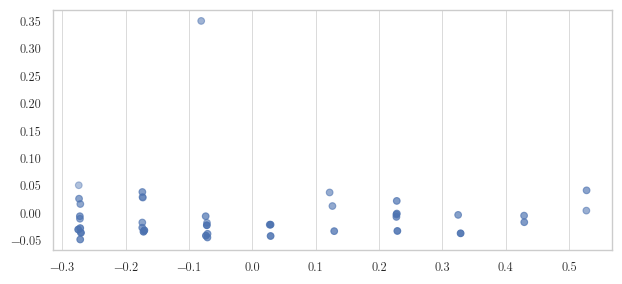

In [418]:
pca = PCA(n_components=2)
cleaned_data = pca_data.query('dP==0.1').drop(columns=['pid', 'dP', 'trials', 'seed', 'mean cues', 'mean correct'])
accuracies = pca_data.query('dP==0.1')['mean correct'].to_numpy()
xs = pca.fit(cleaned_data).transform(cleaned_data)
print(f"explained variance ratio (first two components): {pca.explained_variance_ratio_}")

fig, ax = plt.subplots(figsize=((6.38, 3)))
ax.scatter(xs[:,0], xs[:,1], alpha=accuracies)
plt.tight_layout()

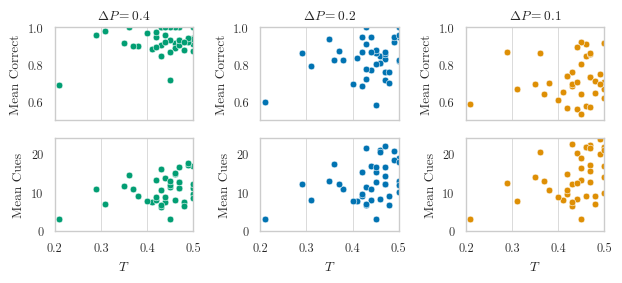

In [428]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True)
sns.scatterplot(data=pca_data.query("dP==0.4"), x='T', y='mean correct', ax=axes[0][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='T', y='mean correct', ax=axes[0][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='T', y='mean correct', ax=axes[0][2], color=palette[1])
sns.scatterplot(data=pca_data.query("dP==0.4"), x='T', y='mean cues', ax=axes[1][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='T', y='mean cues', ax=axes[1][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='T', y='mean cues', ax=axes[1][2], color=palette[1])
axes[0][0].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.4$")
axes[0][1].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.2$")
axes[0][2].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.1$")
axes[1][0].set(xlabel=r'$T$', ylabel='Mean Cues', xticks=((0.2, 0.3, 0.4, 0.5)), xlim=((0.2, 0.5)), ylim=((0, 24)))
axes[1][1].set(xlabel=r'$T$', ylabel='Mean Cues', xticks=((0.2, 0.3, 0.4, 0.5)), xlim=((0.2, 0.5)), ylim=((0, 24)))
axes[1][2].set(xlabel=r'$T$', ylabel='Mean Cues', xticks=((0.2, 0.3, 0.4, 0.5)), xlim=((0.2, 0.5)), ylim=((0, 24)))
plt.tight_layout()

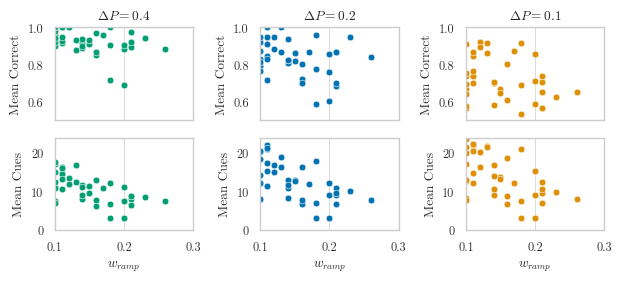

In [429]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True)
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_ramp', y='mean correct', ax=axes[0][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_ramp', y='mean correct', ax=axes[0][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_ramp', y='mean correct', ax=axes[0][2], color=palette[1])
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_ramp', y='mean cues', ax=axes[1][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_ramp', y='mean cues', ax=axes[1][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_ramp', y='mean cues', ax=axes[1][2], color=palette[1])
axes[0][0].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.4$")
axes[0][1].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.2$")
axes[0][2].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.1$")
axes[1][0].set(xlabel=r'$w_{ramp}$', ylabel='Mean Cues', xticks=((0.1, 0.2, 0.3)), xlim=((0.1, 0.3)), ylim=((0, 24)))
axes[1][1].set(xlabel=r'$w_{ramp}$', ylabel='Mean Cues', xticks=((0.1, 0.2, 0.3)), xlim=((0.1, 0.3)), ylim=((0, 24)))
axes[1][2].set(xlabel=r'$w_{ramp}$', ylabel='Mean Cues', xticks=((0.1, 0.2, 0.3)), xlim=((0.1, 0.3)), ylim=((0, 24)))
plt.tight_layout()

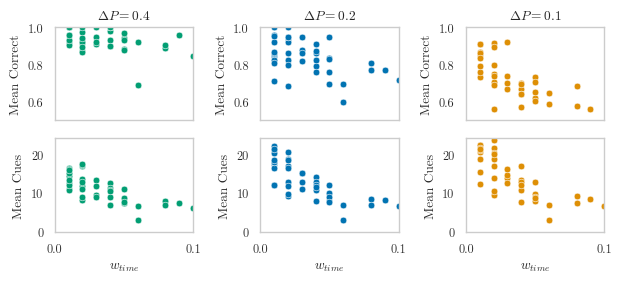

In [433]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True)
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_time', y='mean correct', ax=axes[0][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_time', y='mean correct', ax=axes[0][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_time', y='mean correct', ax=axes[0][2], color=palette[1])
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_time', y='mean cues', ax=axes[1][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_time', y='mean cues', ax=axes[1][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_time', y='mean cues', ax=axes[1][2], color=palette[1])
axes[0][0].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.4$")
axes[0][1].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.2$")
axes[0][2].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.1$")
axes[1][0].set(xlabel=r'$w_{time}$', ylabel='Mean Cues', xticks=((0.0, 0.1)), xlim=((0.0, 0.1)), ylim=((0, 24)))
axes[1][1].set(xlabel=r'$w_{time}$', ylabel='Mean Cues', xticks=((0.0, 0.1)), xlim=((0.0, 0.1)), ylim=((0, 24)))
axes[1][2].set(xlabel=r'$w_{time}$', ylabel='Mean Cues', xticks=((0.0, 0.1)), xlim=((0.0, 0.1)), ylim=((0, 24)))
plt.tight_layout()
fig.savefig("plots/SAT_w_time.png", dpi=600)

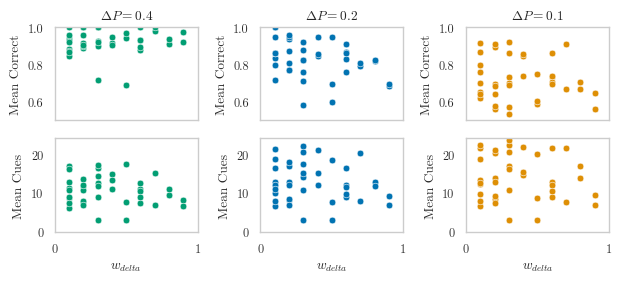

In [431]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=((6.38, 3)), sharex=True)
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_delta', y='mean correct', ax=axes[0][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_delta', y='mean correct', ax=axes[0][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_delta', y='mean correct', ax=axes[0][2], color=palette[1])
sns.scatterplot(data=pca_data.query("dP==0.4"), x='w_delta', y='mean cues', ax=axes[1][0], color=palette[2])
sns.scatterplot(data=pca_data.query("dP==0.2"), x='w_delta', y='mean cues', ax=axes[1][1], color=palette[0])
sns.scatterplot(data=pca_data.query("dP==0.1"), x='w_delta', y='mean cues', ax=axes[1][2], color=palette[1])
axes[0][0].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.4$")
axes[0][1].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.2$")
axes[0][2].set(ylabel='Mean Correct', ylim=((0.5, 1)), title=r"$\Delta P = 0.1$")
axes[1][0].set(xlabel=r'$w_{delta}$', ylabel='Mean Cues', xticks=((0, 1)), xlim=((0, 1)), ylim=((0, 24)))
axes[1][1].set(xlabel=r'$w_{delta}$', ylabel='Mean Cues', xticks=((0, 1)), xlim=((0, 1)), ylim=((0, 24)))
axes[1][2].set(xlabel=r'$w_{delta}$', ylabel='Mean Cues', xticks=((0, 1)), xlim=((0, 1)), ylim=((0, 24)))
plt.tight_layout()

# Empirical SAT

In [140]:
emp = pd.read_pickle("data/collapsed_empirical_data.pkl")

In [ ]:
print(emp['participant_id'].unique())

<AxesSubplot: xlabel='mean cues', ylabel='mean correct'>

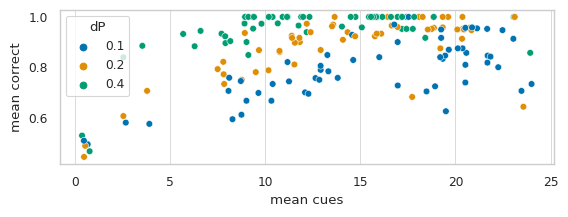

In [143]:
fig, ax = plt.subplots(figsize=((6.38, 2)))
sns.scatterplot(data=emp_collapsed, x='mean cues', y='mean correct', hue='dP', palette=palette[:3])

<AxesSubplot: xlabel='mean cues', ylabel='mean correct'>

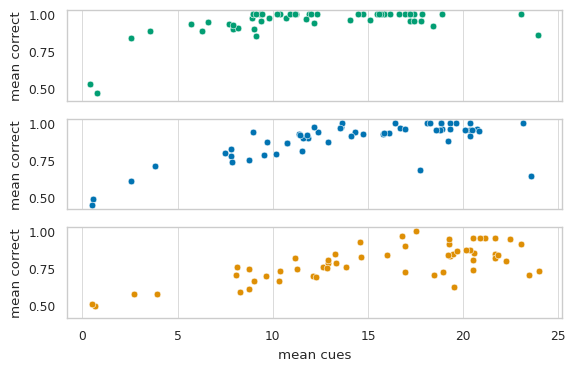

In [142]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True, sharey=True)
sns.scatterplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.scatterplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.scatterplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])

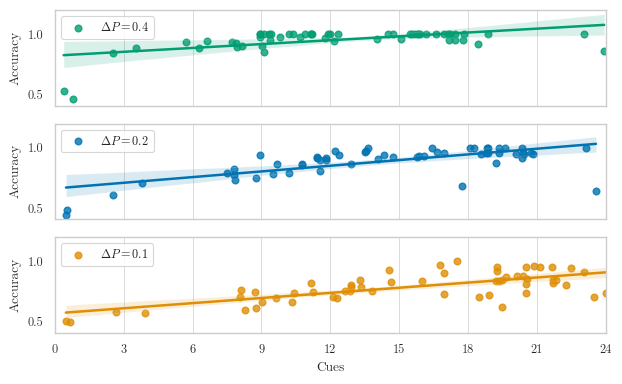

In [161]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=((6.38, 4)), sharex=True, sharey=True)
sns.regplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0], label=r'$\Delta P=0.4$')
sns.regplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1], label=r'$\Delta P=0.2$')
sns.regplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2], label=r'$\Delta P=0.1$')
axes[0].legend(loc='upper left')
axes[1].legend(loc='upper left')
axes[2].legend(loc='upper left')
axes[0].set(ylabel='Accuracy', xlabel=None)
axes[1].set(ylabel='Accuracy', xlabel=None)
axes[2].set(ylabel='Accuracy', xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_empirical.svg")
fig.savefig(f"plots/SAT_empirical.png", dpi=600)

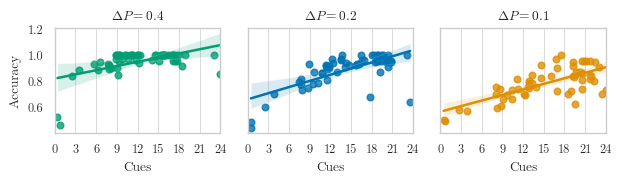

In [167]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=((6.38, 2)), sharex=True, sharey=True)
sns.regplot(data=emp.query("dP==0.4"), x='mean cues', y='mean correct', color=palette[2], ax=axes[0])
sns.regplot(data=emp.query("dP==0.2"), x='mean cues', y='mean correct', color=palette[0], ax=axes[1])
sns.regplot(data=emp.query("dP==0.1"), x='mean cues', y='mean correct', color=palette[1], ax=axes[2])
axes[0].set(ylabel='Accuracy', xlabel='Cues', title=r'$\Delta P=0.4$')
axes[1].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.2$')
axes[2].set(ylabel=None, xlabel='Cues', title=r'$\Delta P=0.1$', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
plt.tight_layout()
fig.savefig(f"plots/SAT_empirical.svg")
fig.savefig(f"plots/SAT_empirical.png", dpi=600)

## Replot

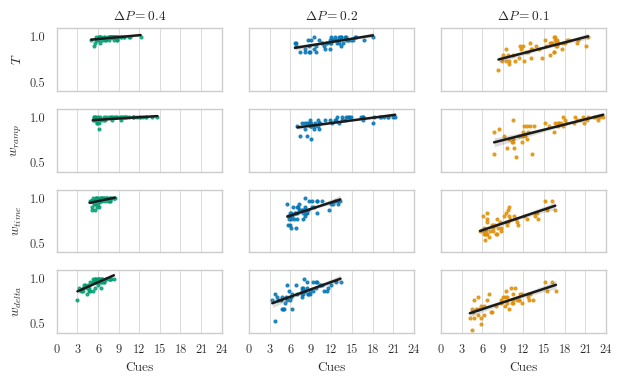

In [188]:
nNetworks=50
nTrials=30
data_T = pd.read_pickle(f"data/scan_T_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
data_w_ramp = pd.read_pickle(f"data/scan_w_ramp_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
data_w_time = pd.read_pickle(f"data/scan_w_time_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")
data_w_delta = pd.read_pickle(f"data/scan_w_delta_nNetworks{nNetworks}_nTrials{nTrials}_collapsed.pkl")

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=((6.38, 4)), sharex=True, sharey=True)
sns.regplot(data=data_T.query("dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[2], ax=axes[0][0])
sns.regplot(data=data_T.query("dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[0], ax=axes[0][1])
sns.regplot(data=data_T.query("dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[1], ax=axes[0][2])

sns.regplot(data=data_w_ramp.query("dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[2], ax=axes[1][0])
sns.regplot(data=data_w_ramp.query("dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[0], ax=axes[1][1])
sns.regplot(data=data_w_ramp.query("dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[1], ax=axes[1][2])

sns.regplot(data=data_w_time.query("dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[2], ax=axes[2][0])
sns.regplot(data=data_w_time.query("dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[0], ax=axes[2][1])
sns.regplot(data=data_w_time.query("dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[1], ax=axes[2][2])

sns.regplot(data=data_w_delta.query("dP==0.4"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[2], ax=axes[3][0])
sns.regplot(data=data_w_delta.query("dP==0.2"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[0], ax=axes[3][1])
sns.regplot(data=data_w_delta.query("dP==0.1"), x='mean cues', y='mean correct', scatter_kws={'s': 4}, line_kws={'color': 'k'}, color=palette[1], ax=axes[3][2])

# axes[0][0].set(ylabel='Accuracy', xlabel=None, title=r'$\Delta P=0.4$')
axes[0][0].set(ylabel=r'$T$', xlabel=None, title=r'$\Delta P=0.4$')
axes[0][1].set(ylabel=None, xlabel=None, title=r'$\Delta P=0.2$')
axes[0][2].set(ylabel=None, xlabel=None, title=r'$\Delta P=0.1$')

axes[1][0].set(ylabel=r'$w_{ramp}$', xlabel=None)
axes[1][1].set(ylabel=None, xlabel=None)
axes[1][2].set(ylabel=None, xlabel=None)

axes[2][0].set(ylabel=r'$w_{time}$', xlabel=None)
axes[2][1].set(ylabel=None, xlabel=None)
axes[2][2].set(ylabel=None, xlabel=None)

axes[3][0].set(ylabel=r'$w_{delta}$', xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[3][1].set(ylabel=None, xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))
axes[3][2].set(ylabel=None, xlabel='Cues', xticks=np.arange(0, 27, 3), xlim=((0, 24)))

plt.tight_layout()
fig.savefig(f"plots/scans.svg")
fig.savefig(f"plots/scans.png", dpi=600)

## load nni result

In [435]:
# f = open('nni_result.json')
f = open('o')
result = json.load(f)
min_loss = 1000
params = {}
for trial in result:
    loss = int(trial['value'])
    if loss <= min_loss:
        min_loss = loss
        params = trial['parameter']
print(params, min_loss)

{'seed': 823, 'T': 0.41000000000000003, 'w_ramp': 0.16, 'w_time': 0.04, 'w_delta': 0.30000000000000004} 168
